In [88]:
import os
import util
from scipy import sparse
import numpy as np
from collections import Counter
import pandas as pd
import random
from matplotlib import pyplot as plt
%matplotlib inline

try:
    import xml.etree.cElementTree as ET
except ImportError:
    import xml.etree.ElementTree as ET

In [89]:
direc = 'train'

fake_ids = []
classes = []
i = 0

for datafile in os.listdir(direc):
    if datafile == '.DS_Store':
        continue

    i += 1

    # extract id and true class (if available) from filename
    id_str, clazz = datafile.split('.')[:2]
    fake_ids.append(str(datafile))
    try:
        classes.append(util.malware_classes.index(clazz))

    except ValueError:
        # we should only fail to find the label in our list of malware classes
        # if this is test data, which always has an "X" label
        assert clazz == "X"
        classes.append(-1)

df = pd.DataFrame()
df['ids'] = fake_ids
df['class'] = classes

In [90]:
from sklearn.cross_validation import train_test_split
train_df, test_df = train_test_split(df, test_size = 0.33)

In [91]:
def check_swizzor(direc, datafile) :
    tree = ET.parse(os.path.join(direc,datafile))
    root = tree.getroot()
    process = []
    
    for child in root :
        if type(child) is not str :
            if 'filename' in child.attrib.keys() :
                process.append(child.attrib['filename'])
        
    for i in range(len(process) - 1) :
        first = process[i]
        second = process[i+1]
        
        if "iexplore.exe" in first and ("services.exe" in second or "svchost.exe" in second):
            return 10
            break
    
    return -1

In [92]:
mask = []
estimate = []
for ID in test_df.ids :
    guess = check_swizzor('train',ID)
    if guess == 10 :
        mask.append(False)
    else :
        mask.append(True)
    estimate.append(guess)

In [93]:
test_df['swizzor'] = estimate

/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [94]:
ids_left = [el[1] for el in zip(mask, test_df.ids) if el[0] == True]

In [95]:
train_proc = []
for ID in train_df.ids : 
    proc = []
    tree = ET.parse(os.path.join('train',ID))
    for el in tree.iter() :
        proc.append(el.tag)
    train_proc.append(proc)

In [96]:
train_proc_lengths = [len(process) for process in train_proc]

In [97]:
def most_common(lst):
        return max(set(lst), key=lst.count)

estimate = []
xml_mask = []

for ID in ids_left :
    proc = []
    tree = ET.parse(os.path.join('train',ID))
    for el in tree.iter() :
        proc.append(el.tag)
    u_length = len(proc)
    
    length_mask = [True if length == u_length else False for length in train_proc_lengths]
    if np.sum(length_mask) > 7 :
        dftouse = train_df[length_mask]
        estimate.append(most_common(dftouse['class'].tolist()))
        xml_mask.append(False)
    else :
        estimate.append(-1)
        xml_mask.append(True)

In [98]:
merge_df = pd.DataFrame()
merge_df['ids'] = ids_left
merge_df['xml_match'] = estimate
post_df = test_df.merge(merge_df, how='outer')

def find_class(array) :
    for el in array[2:] :
        if type(el) != str and el != -1 :
            return el
    return -1

post_df['pred'] = post_df.apply(find_class, axis=1)

ids_left_2 = post_df[post_df['pred'] == -1].ids

In [99]:
def create_feats(direc, ids) :
    X = None
    for ID in ids :
        tree = ET.parse(os.path.join(direc,ID))
        this_row = call_feats(tree)
        
        if X is None:
            X = this_row 
        else:
            X = np.vstack((X, this_row))
    return X
        
def add_to_set(tree):
    for el in tree.iter():
        call = el.tag
        call_set.add(call)
        
def call_feats(tree):
    calls = ['all_section', 'bind_socket', 'check_for_debugger',
       'com_create_instance', 'com_get_class_object', 'connect',
       'connect_socket', 'copy_file', 'create_directory', 'create_file',
       'create_key', 'create_mutex', 'create_open_file', 'create_process',
       'create_socket', 'create_thread', 'create_window', 'delete_file',
       'delete_key', 'delete_value', 'destroy_window', 'dump_line',
       'enum_keys', 'enum_processes', 'enum_values', 'enum_window',
       'find_file', 'find_window', 'get_computer_name',
       'get_file_attributes', 'get_host_by_name', 'get_system_directory',
       'get_system_time', 'get_username', 'get_windows_directory',
       'impersonate_user', 'kill_process', 'load_dll', 'load_image',
       'open_file', 'open_key', 'open_mutex', 'open_process',
       'open_scmanager', 'open_service', 'open_url', 'process',
       'processes', 'query_value', 'read_section', 'read_value',
       'recv_socket', 'remove_directory', 'send_socket',
       'set_file_attributes', 'set_file_time', 'set_value',
       'set_windows_hook', 'show_window', 'sleep', 'thread',
       'trimmed_bytes', 'vm_protect', 'write_value']

    call_counter = {}
    for el in tree.iter():
        call = el.tag
        if call not in call_counter:
            call_counter[call] = 0
        else:
            call_counter[call] += 1

    call_feat_array = np.zeros(len(calls))
    for i in range(len(calls)):
        call = calls[i]
        call_feat_array[i] = 0
        if call in call_counter:
            call_feat_array[i] = call_counter[call]

    return call_feat_array

In [100]:
X_train = create_feats('train', train_df.ids)
y_train = train_df['class']

In [101]:
X_test = create_feats('train', ids_left_2)

In [102]:
regression_df = pd.DataFrame()
regression_df['ids'] = ids_left_2

In [103]:
from sklearn import linear_model
LR = linear_model.LogisticRegression()
LR.fit(X_train, y_train)
regression_df['LogReg'] = LR.predict(X_test)

In [104]:
from sklearn import neighbors
n_neighbors = 15

clf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
clf.fit(X_train, y_train)
regression_df['KNN'] = clf.predict(X_test)

In [105]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=10)
clf.fit(X_train, y_train)
regression_df['RF'] = clf.predict(X_test)

In [106]:
def bestGuess(array) :
    LR = array[1]
    KNN = array[2]
    RF = array[3]
    return RF

regression_df['bestGuess'] = regression_df.apply(bestGuess, 1)

In [107]:
final_df = post_df.merge(regression_df[['ids','bestGuess']], how="outer")
final_df['pred'] = final_df.apply(find_class, axis=1)

0.869479882237


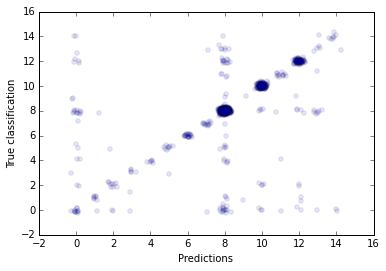

In [108]:
def rand_jitter(arr):
    stdev = .01*(max(arr)-min(arr))
    return arr + np.random.randn(len(arr)) * stdev

def accuracy_score(arr1, arr2) :
    arr1 = np.array(arr1)
    arr2 = np.array(arr2)
    
    if arr1.shape == arr2.shape :
        print len(np.where(arr1 == arr2)[0])/float(arr1.shape[0])
    
    plt.scatter(rand_jitter(arr1), rand_jitter(arr2), alpha=0.1);
    plt.xlabel('Predictions');
    plt.ylabel('True classification');
    
accuracy_score(final_df['pred'], final_df['class'])